#### 短面板数据

In [54]:
import os
import stata_setup
from tensorflow.python.ops.numpy_ops import argmin

## 设置pystata目录
stata_setup.config(os.getenv("STATA_SYSDIR"), 'mp')

%stata use "wagepan.dta", clear

In [55]:
## 设置数据为追踪数据
%stata xtset nr year


Panel variable: nr (strongly balanced)
 Time variable: year, 1980 to 1987
         Delta: 1 unit


In [56]:
## 查看字段信息
%stata describe


Contains data from wagepan.dta
 Observations:         4,360                  
    Variables:            10                  17 Jul 2023 12:37
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
nr              int     %9.0g                 person identifier
year            int     %9.0g                 1980 to 1987
black           byte    %9.0g                 =1 if black
hisp            byte    %9.0g                 =1 if Hispanic
married         byte    %9.0g                 =1 if married
educ            byte    %9.0g                 years of schooling
exper           byte    %9.0g                 labor mkt experience
exper2          float   %9.0g                 =exper^2
union           byte    %9.0g                 =1 if in union
lwage           float   %9.0g                

In [57]:
## 描述数据缺失情况
%stata xtdescribe


      nr:  13, 17, ..., 12548                                n =        545
    year:  1980, 1981, ..., 1987                             T =          8
           Delta(year) = 1 unit
           Span(year)  = 8 periods
           (nr*year uniquely identifies each observation)

Distribution of T_i:   min      5%     25%       50%       75%     95%     max
                         8       8       8         8         8       8       8

     Freq.  Percent    Cum. |  Pattern
 ---------------------------+----------
      545    100.00  100.00 |  11111111
 ---------------------------+----------
      545    100.00         |  XXXXXXXX


In [58]:
## 描述变量的组内和组间方差。组间（between）指的是对不同观察期取均值以后的结果，组内（within）指的是对变量的原始值进行均值差分以后的结果
%stata xtsum lwage black hisp educ year married exper exper2 union


Variable         |      Mean   Std. dev.       Min        Max |    Observations
-----------------+--------------------------------------------+----------------
lwage    overall |  1.649147   .5326094  -3.579079    4.05186 |     N =    4360
         between |             .3907468   .3333435   3.174173 |     n =     545
         within  |             .3622636  -2.467201   3.204687 |     T =       8
                 |                                            |
black    overall |  .1155963   .3197769          0          1 |     N =    4360
         between |              .320034          0          1 |     n =     545
         within  |                    0   .1155963   .1155963 |     T =       8
                 |                                            |
hisp     overall |  .1559633   .3628622          0          1 |     N =    4360
         between |             .3631539          0          1 |     n =     545
         within  |                    0   .1559633   .1559633 |     T =

$lwage$、$married$、$exper$、$exper2$和$union$的组间标准差和组内标准差均大于0。因此，这些变量既有组间差异（$\overline{y}_{i}$），也有组内差异（$y_{it}-\overline{y}_{i}$）。组内差异大于0意味着这些变量的值会随时间发生变化，因此这些变量是时变变量。<br>
相比之下，$black$、$hisp$和$educ$的组间标准差大于0，组内标准差等于0。因此，这些变量只有组间差异，没有组内差异。组内差异为0意味着这些变量的值不随时间变化，因此这些变量是非时变变量。<br>
最后，year的组件标准差为0，组内标准差大于0。因此，该变量只有组内差异，没有组间差异。<br>
在面板数据中，通常只有时间变量或与时间同步发生变化的变量（如研究对象年龄）才具有组间差异为0而组内差异大于0的特征。<br>
在面板数据分析时，区分组间差异和组内差异很重要，因为有些估计量只使用组内差异（如固定效应模型估计量），才使用这些估计量无法分析非时变变量对i你变量的影响

In [77]:
from pystata import stata

data = stata.pdataframe_from_data()
data.head()

,nr,year,black,hisp,married,educ,exper,exper2,union,lwage
0,13,1980,0,0,0,14,1,1.0,0,1.197540
1,13,1981,0,0,0,14,2,4.0,1,1.853060
2,13,1982,0,0,0,14,3,9.0,0,1.344462
3,13,1983,0,0,0,14,4,16.0,0,1.433213
4,13,1984,0,0,0,14,5,25.0,0,1.568125


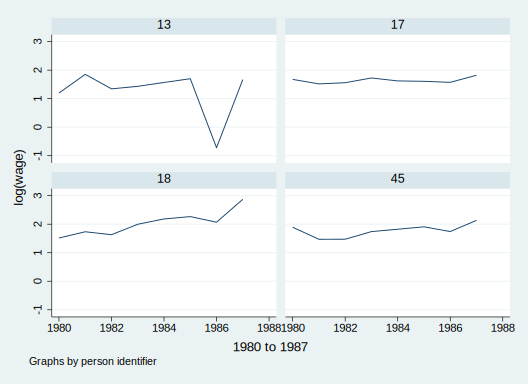

In [80]:
## 描述个体时间序列
%stata xtline lwage if nr<100

In [81]:
## 混合线性回归
%stata xtreg lwage black hisp union married exper exper2 year educ, pa corr(independent) vce(robust)


Iteration 1: tolerance = 1.346e-10

GEE population-averaged model                      Number of obs    =    4,360
Group variable: nr                                 Number of groups =      545
Family: Gaussian                                   Obs per group:  
Link:   Identity                                                min =        8
Correlation: independent                                        avg =      8.0
                                                                max =        8
                                                   Wald chi2(8)     =   621.34
Scale parameter = .2300891                         Prob > chi2      =   0.0000

Pearson chi2(4360)   =  1003.19                    Deviance         =  1003.19
Dispersion (Pearson) = .2300891                    Dispersion       = .2300891

                                     (Std. err. adjusted for clustering on nr)
------------------------------------------------------------------------------
             |          

In [82]:
## regress 与 xtreg 命令等价
%stata regress lwage black hisp union married exper exper2 year educ, vce(cluster nr)


Linear regression                               Number of obs     =      4,360
                                                F(8, 544)         =      77.52
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1887
                                                Root MSE          =     .48017

                                   (Std. err. adjusted for 545 clusters in nr)
------------------------------------------------------------------------------
             |               Robust
       lwage | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       black |  -.1392244   .0504743    -2.76   0.006    -.2383728    -.040076
        hisp |   .0158267   .0389758     0.41   0.685    -.0607348    .0923882
       union |   .1830538   .0274182     6.68   0.000     .1291954    .2369122
     married |

不过，使用xtreg命令可以通过corr()选项设定误差项的自相关模式，从而得到更有效率的系数估计值

In [89]:
## 固定效应模型（固定效应模型只能计算时变变量对因变量的影响）
stata.run(
    """
    // LSDV法
    qui regress lwage union married exper exper2 i.nr, vce(cluster nr)
    estimates table, keep(union married exper exper2) b se
    """
)
print('==============================================================')
stata.run(
    """
    // 均值差分法
    xtreg lwage union married exper exper2, fe vce(robust)
    """
)
print('==============================================================')
stata.run(
    """
    // 一阶差分法
    regress D.(lwage union married exper exper2), vce(cluster nr) noconstant
    """
)


. 
.     // 注意：固定效应模型只能计算时变变量对因变量的影响
.     qui regress lwage union married exper exper2 i.nr, vce(cluster nr)

.     estimates table, keep(union married exper exper2) b se

---------------------------
    Variable |   Active    
-------------+-------------
       union |  .08208713  
             |  .02440148  
     married |  .04530332  
             |  .02245327  
       exper |  .11684669  
             |   .0114521  
      exper2 | -.00430089  
             |  .00073343  
---------------------------
               Legend: b/se

.     
. 

. 
.     // 均值差分法
.     xtreg lwage union married exper exper2, fe vce(robust)

Fixed-effects (within) regression               Number of obs     =      4,360
Group variable: nr                              Number of groups  =        545

R-squared:                                      Obs per group:
     Within  = 0.1780                                         min =          8
     Between = 0.0005                                         avg =  

考虑到均值差分法的估计效率更高，因此我们建议研究者使用均值差分法求解

In [90]:
## 随机效应模型（同时使用了组内信息和组间信息，因此可以估计非时变变量对因变量的影响）
stata.run(
    """
    // 广义最小二乘估计
    xtreg lwage black hisp union married exper exper2 year educ, re theta vce(robust)
    """
)
print('=============================================================================')
stata.run(
    """
    // 最大似然估计（如果随机效应u_i和误差项e_it均服从正态分布，那么可以通过选项mle获取更有效率的估计值）
    xtreg lwage black hisp union married exper exper2 year educ, mle vce(bootstrap)
    """
)
print('==============================================================================')
stata.run(
    """
    // 组间估计量
    xtreg lwage black hisp union married exper exper2 year educ, be vce(bootstrap)
    """
)


. 
.     // 广义最小二乘估计
.     xtreg lwage black hisp union married exper exper2 year educ, re theta vce(robust)

Random-effects GLS regression                   Number of obs     =      4,360
Group variable: nr                              Number of groups  =        545

R-squared:                                      Obs per group:
     Within  = 0.1774                                         min =          8
     Between = 0.1881                                         avg =        8.0
     Overall = 0.1829                                         max =          8

                                                Wald chi2(8)      =     573.35
corr(u_i, X) = 0 (assumed)                      Prob > chi2       =     0.0000
theta        = .64264094

                                   (Std. err. adjusted for 545 clusters in nr)
------------------------------------------------------------------------------
             |               Robust
       lwage | Coefficient  std. err.      z    P>|

对比固定效应估计量、随机效应估计量和组间估计量，可以发现，RE估计量位于FE（组间估计量）和BE（组间估计量）的加权平均结果。

In [92]:
## Hausman检验
stata.run(
    """
    qui xtreg lwage union married exper exper2, fe
    est store fe
    qui xtreg lwage black hisp union married exper exper2 year educ, re
    est store re
    hausman fe re, sigmamore
    """
)



. 
.     qui xtreg lwage union married exper exper2, fe

.     est store fe

.     qui xtreg lwage black hisp union married exper exper2 year educ, re

.     est store re

.     hausman fe re, sigmamore

                 ---- Coefficients ----
             |      (b)          (B)            (b-B)     sqrt(diag(V_b-V_B))
             |       fe           re         Difference       Std. err.
-------------+----------------------------------------------------------------
       union |    .0820871     .1080178       -.0259307        .0074844
     married |    .0453033     .0629524       -.0176491         .007462
       exper |    .1168467     .0942591        .0225876               .
      exper2 |   -.0043009    -.0039663       -.0003346        .0001159
------------------------------------------------------------------------------
                          b = Consistent under H0 and Ha; obtained from xtreg.
           B = Inconsistent under Ha, efficient under H0; obtained from xtreg.



In [98]:
## 稳健的Hausman检验（放松随机效应模型的误差项服从独立同分布假定）
stata.run(
    """
    qui xtreg lwage black hisp union married exper exper2 year educ, re vce(robust)
    xtoverid
    """
)


. 
.     qui xtreg lwage black hisp union married exper exper2 year educ, re vce(robust)

.     xtoverid

Test of overidentifying restrictions: fixed vs random effects
Cross-section time-series model: xtreg re  robust cluster(nr)
Sargan-Hansen statistic  28.711  Chi-sq(4)    P-value = 0.0000

.     
. 


#### 长面板数据

In [99]:
%stata use "mus08cigar.dta", clear

In [100]:
## 设置为面板数据
%stata xtset state year


Panel variable: state (strongly balanced)
 Time variable: year, 63 to 92
         Delta: 1 unit


In [101]:
## LSDV法拟合个体效应模型，将时间T作为连续变量纳入模型
%stata reg lnc lnp lny lnpmin i.state year, vce(cluster state)


Linear regression                               Number of obs     =        300
                                                F(3, 9)           =          .
                                                Prob > F          =          .
                                                R-squared         =     0.7203
                                                Root MSE          =     .11203

                                 (Std. err. adjusted for 10 clusters in state)
------------------------------------------------------------------------------
             |               Robust
         lnc | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
         lnp |  -1.027181   .4412156    -2.33   0.045     -2.02528   -.0290819
         lny |   .4975365   .4139086     1.20   0.260    -.4387899    1.433863
      lnpmin |   .5100582   .2627025     1.94   0.084    -.0842161    1.104332
             |

In [108]:
## 直接使用聚类稳健标准误，估计效率偏低。因此，考虑采用更有效率的估计方法。
stata.run(
    """
    // 检验组间异方差
    qui xtreg lnc lnp lny lnpmin year, fe vce(robust)
    xttest3
    // 检验组内自相关
    xi:xtserial lnc lnp lny lnpmin year i.state
    // 检验组间同期相关
    set linesize 150
    qui xtreg lnc lnp lny lnpmin year, fe vce(robust)
    xttest2
    """
)


. 
.     // 检验组间异方差
.     qui xtreg lnc lnp lny lnpmin year, fe vce(robust)

.     xttest3

Modified Wald test for groupwise heteroskedasticity
in fixed effect regression model

H0: sigma(i)^2 = sigma^2 for all i

chi2 (10)  =         378.90
Prob > chi2 =          0.0000


.     // 检验组内自相关
.     xi:xtserial lnc lnp lny lnpmin year i.state
i.state           _Istate_1-10        (naturally coded; _Istate_1 omitted)

Wooldridge test for autocorrelation in panel data
H0: no first-order autocorrelation
    F(  1,       9) =     89.304
           Prob > F =      0.0000

.     // 检验组间同期相关
.     set linesize 150

.     qui xtreg lnc lnp lny lnpmin year, fe vce(robust)

.     xttest2
 
Correlation matrix of residuals:

             |      __e1       __e2       __e3       __e4       __e5       __e6       __e7       __e8       __e9      __e10 
-------------+--------------------------------------------------------------------------------------------------------------
        __e1 |  .2921489      

In [109]:
## 面板校正标准误
%stata xtpcse lnc lnp lny lnpmin year i.state


Linear regression, correlated panels corrected standard errors (PCSEs)

Group variable:   state                         Number of obs     =        300
Time variable:    year                          Number of groups  =         10
Panels:           correlated (balanced)         Obs per group:
Autocorrelation:  no autocorrelation                          min =         30
                                                              avg =         30
                                                              max =         30
Estimated covariances      =        55          R-squared         =     0.7203
Estimated autocorrelations =         0          Wald chi2(13)     =    2147.36
Estimated coefficients     =        14          Prob > chi2       =     0.0000

------------------------------------------------------------------------------
             |           Panel-corrected
         lnc | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+------------------

In [110]:
## 面板校正标准误+FGLS,所有个案均遵守相同的自相关模式
%stata xtpcse lnc lnp lny lnpmin year i.state, corr(ar1)

note: estimates of rho outside [-1,1] bounded to be in the range [-1,1].

Prais–Winsten regression, correlated panels corrected standard errors (PCSEs)

Group variable:   state                         Number of obs     =        300
Time variable:    year                          Number of groups  =         10
Panels:           correlated (balanced)         Obs per group:
Autocorrelation:  common AR(1)                                min =         30
                                                              avg =         30
                                                              max =         30
Estimated covariances      =        55          R-squared         =     0.9824
Estimated autocorrelations =         1          Wald chi2(13)     =     504.30
Estimated coefficients     =        14          Prob > chi2       =     0.0000

------------------------------------------------------------------------------
             |           Panel-corrected
         lnc | Coefficient  std

In [111]:
## 假定组内自相关模式为一阶自回归，且自回归的系数因个案而异
%stata xtpcse lnc lnp lny lnpmin year i.state, corr(psar1)

note: estimates of rho outside [-1,1] bounded to be in the range [-1,1].

Prais–Winsten regression, correlated panels corrected standard errors (PCSEs)

Group variable:   state                         Number of obs     =        300
Time variable:    year                          Number of groups  =         10
Panels:           correlated (balanced)         Obs per group:
Autocorrelation:  panel-specific AR(1)                        min =         30
                                                              avg =         30
                                                              max =         30
Estimated covariances      =        55          R-squared         =     0.9954
Estimated autocorrelations =        10          Wald chi2(12)     =     855.24
Estimated coefficients     =        13          Prob > chi2       =     0.0000

------------------------------------------------------------------------------
             |           Panel-corrected
         lnc | Coefficient  std

In [112]:
## 全面FGLS
%stata xtgls lnc lnp lny lnpmin year i.state, panels(cor) corr(ar1)


Cross-sectional time-series FGLS regression

Coefficients:  generalized least squares
Panels:        heteroskedastic with cross-sectional correlation
Correlation:   common AR(1) coefficient for all panels  (0.7967)

Estimated covariances      =        55          Number of obs     =        300
Estimated autocorrelations =         1          Number of groups  =         10
Estimated coefficients     =        14          Time periods      =         30
                                                Wald chi2(13)     =     797.11
                                                Prob > chi2       =     0.0000

------------------------------------------------------------------------------
         lnc | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
         lnp |  -.3629823   .0239353   -15.17   0.000    -.4098947   -.3160699
         lny |   .5116673   .0733079     6.98   0.000     .3679865     

In [113]:
%stata xtgls lnc lnp lny lnpmin year i.state, panels(cor) corr(psar1)


Cross-sectional time-series FGLS regression

Coefficients:  generalized least squares
Panels:        heteroskedastic with cross-sectional correlation
Correlation:   panel-specific AR(1)

Estimated covariances      =        55          Number of obs     =        300
Estimated autocorrelations =        10          Number of groups  =         10
Estimated coefficients     =        14          Time periods      =         30
                                                Wald chi2(13)     =    1246.78
                                                Prob > chi2       =     0.0000

------------------------------------------------------------------------------
         lnc | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
         lnp |  -.3541126    .024395   -14.52   0.000    -.4019259   -.3062994
         lny |   .5459469   .0712941     7.66   0.000      .406213    .6856808
      lnpmin |   .018

#### 动态面板模型

In [115]:
stata.run(
    """
    use "wagepan.dta", clear
    // 设置为面板数据
    xtset nr year
    """
)


. 
.     use "wagepan.dta", clear

.     // 设置为面板数据
.     xtset nr year

Panel variable: nr (strongly balanced)
 Time variable: year, 1980 to 1987
         Delta: 1 unit

.     
. 


In [116]:
## 固定效应模型
%stata xtreg lwage L.lwage union married exper exper2, fe vce(robust)


Fixed-effects (within) regression               Number of obs     =      3,815
Group variable: nr                              Number of groups  =        545

R-squared:                                      Obs per group:
     Within  = 0.1440                                         min =          7
     Between = 0.0549                                         avg =        7.0
     Overall = 0.0899                                         max =          7

                                                F(5,544)          =      67.60
corr(u_i, Xb) = 0.0078                          Prob > F          =     0.0000

                                   (Std. err. adjusted for 545 clusters in nr)
------------------------------------------------------------------------------
             |               Robust
       lwage | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       lwage |
         L1. 

上述xtreg命令虽然通过选项fe纳入了个体层面的固定效应，但其估计值依然是有偏的
其原因在于自变量中包含了因变量的一阶滞后L.lwage,它必然与均值差分后的模型误差项存在相关。因此，该模型存在内生性问题

In [117]:
## Arellano-Bond估计量（差分GMM）
%stata xtabond lwage union married exper exper2, lags(1) twostep vce(robust)


Arellano–Bond dynamic panel-data estimation     Number of obs     =      3,270
Group variable: nr                              Number of groups  =        545
Time variable: year
                                                Obs per group:
                                                              min =          6
                                                              avg =          6
                                                              max =          6

Number of instruments =     26                  Wald chi2(5)      =     358.64
                                                Prob > chi2       =     0.0000
Two-step results
                                     (Std. err. adjusted for clustering on nr)
------------------------------------------------------------------------------
             |              WC-robust
       lwage | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+--------------------------------------------------------

In [120]:
## 设置前定变量和同期内生解释变量, 软件会自动根据变量类型生成工具变量来求解
%stata xtabond lwage exper exper2, lags(1) pre(married) endogenous(union) twostep vce(robust)


Arellano–Bond dynamic panel-data estimation     Number of obs     =      3,270
Group variable: nr                              Number of groups  =        545
Time variable: year
                                                Obs per group:
                                                              min =          6
                                                              avg =          6
                                                              max =          6

Number of instruments =     72                  Wald chi2(5)      =     326.26
                                                Prob > chi2       =     0.0000
Two-step results
                                     (Std. err. adjusted for clustering on nr)
------------------------------------------------------------------------------
             |              WC-robust
       lwage | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+--------------------------------------------------------

In [121]:
## 手动设置工具变量最多使用的滞后期数
%stata xtabond lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust)


Arellano–Bond dynamic panel-data estimation     Number of obs     =      3,270
Group variable: nr                              Number of groups  =        545
Time variable: year
                                                Obs per group:
                                                              min =          6
                                                              avg =          6
                                                              max =          6

Number of instruments =     46                  Wald chi2(5)      =     341.01
                                                Prob > chi2       =     0.0000
Two-step results
                                     (Std. err. adjusted for clustering on nr)
------------------------------------------------------------------------------
             |              WC-robust
       lwage | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+--------------------------------------------------------

结果显示，限定工具变量的滞后期数以后，估计效率明显提升，很多变量的统计检验效果从之前的不显著变为显著<br>
这反映出了使用$xtabond$命令求解动态面板模型时的一个常见问题，即滞后阶数较高的工具变量往往是弱工具变量。因此，研究者需要进行多次尝试，限定工具变量的滞后阶数，以获得最优效率的系数估计值

In [122]:
## 检验误差项是否存在自相关
stata.run(
    """
    qui xtabond lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust) artests(3)
    estat abond
    """
)


. 
.     qui xtabond lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust) artests(3)

.     estat abond

Arellano–Bond test for zero autocorrelation in first-differenced errors
H0: No autocorrelation 

Order         z   Prob > z
--------------------------
    1   -6.4595     0.0000
    2   1.9256      0.0541
    3   -.6321      0.5273
--------------------------

.     
. 


需要注意的是，使用差分$GMM$法求解动态面板模型的假定是：原始误差项不存在自相关。<br>
但是，即便在该假定成立的情况下，一阶差分后的模型误差项依然会存在一阶自相关，但不应存在二阶以上的自相关。

In [123]:
%%stata
// 检验是否所有工具变量都有效
qui xtabond lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep
estat sargan


. // 检验是否所有工具变量都有效
. qui xtabond lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep

. estat sargan
Sargan test of overidentifying restrictions
H0: Overidentifying restrictions are valid

        chi2(40)     =  49.41392
        Prob > chi2  =    0.1462

. 


In [125]:
## 使用xtdpdsys命令（系统GMM）
%stata xtdpdsys lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust)


System dynamic panel-data estimation            Number of obs     =      3,815
Group variable: nr                              Number of groups  =        545
Time variable: year
                                                Obs per group:
                                                              min =          7
                                                              avg =          7
                                                              max =          7

Number of instruments =     65                  Wald chi2(5)      =     348.35
                                                Prob > chi2       =     0.0000
Two-step results
------------------------------------------------------------------------------
             |              WC-robust
       lwage | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       lwage |
         L1. |   .2324316   .0351004     6.62   0.000  

In [126]:
## 纳入非时变变量
%stata xtdpdsys lwage exper exper2 black hisp educ, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust)

note: black omitted from div() because of collinearity.
note: hisp omitted from div() because of collinearity.
note: educ omitted from div() because of collinearity.

System dynamic panel-data estimation            Number of obs     =      3,815
Group variable: nr                              Number of groups  =        545
Time variable: year
                                                Obs per group:
                                                              min =          7
                                                              avg =          7
                                                              max =          7

Number of instruments =     65                  Wald chi2(8)      =     373.15
                                                Prob > chi2       =     0.0000
Two-step results
------------------------------------------------------------------------------
             |              WC-robust
       lwage | Coefficient  std. err.      z    P>|z|     [95%

系统$GMM$法在估计时结合了水平方程，所以可以估计非时变变量的回归系数

In [127]:
%%stata
// 检验误差项是否存在自相关
qui xtdpdsys lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust) artests(3)
estat abond


. // 检验误差项是否存在自相关
. qui xtdpdsys lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust) artests(3)

. estat abond

Arellano–Bond test for zero autocorrelation in first-differenced errors
H0: No autocorrelation 

Order         z   Prob > z
--------------------------
    1   -6.9591     0.0000
    2   2.693       0.0071
    3   -.38028     0.7037
--------------------------

. 


二阶及以上的自相关显著不为0，则说明需要拒绝误差项无自相关的假定。因此，上述系统$GMM$的求解结果很值得怀疑

In [128]:
%%stata
//检验是否所有工具变量都有效
qui xtdpdsys lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep
estat sargan


. //检验是否所有工具变量都有效
. qui xtdpdsys lwage exper exper2, lags(1) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep

. estat sargan
Sargan test of overidentifying restrictions
H0: Overidentifying restrictions are valid

        chi2(59)     =   89.6082
        Prob > chi2  =    0.0062

. 


结合之前对误差项无自相关得检验结果，上述系统$GMM$法得估计结果并不可信。在这种情况下，我们需要修改模型设置

In [131]:
%%stata
## 模型修正
qui xtdpdsys lwage exper exper2, lags(2) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust) artests(3)
estat abond

qui xtdpdsys lwage exper exper2, lags(2) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep
estat sargan


. ## 模型修正
Unknown #command
. qui xtdpdsys lwage exper exper2, lags(2) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust) artests(3)

. estat abond

Arellano–Bond test for zero autocorrelation in first-differenced errors
H0: No autocorrelation 

Order         z   Prob > z
--------------------------
    1   -5.8335     0.0000
    2   -.33194     0.7399
    3   .81621      0.4144
--------------------------

. 
. qui xtdpdsys lwage exper exper2, lags(2) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep

. estat sargan
Sargan test of overidentifying restrictions
H0: Overidentifying restrictions are valid

        chi2(53)     =  64.75773
        Prob > chi2  =    0.1291

. 


In [133]:
## 最终求解的模型
%stata xtdpdsys lwage exper exper2, lags(2) pre(married) endogenous(union) maxldep(3) maxlags(3) twostep vce(robust)


System dynamic panel-data estimation            Number of obs     =      3,270
Group variable: nr                              Number of groups  =        545
Time variable: year
                                                Obs per group:
                                                              min =          6
                                                              avg =          6
                                                              max =          6

Number of instruments =     60                  Wald chi2(6)      =     375.18
                                                Prob > chi2       =     0.0000
Two-step results
------------------------------------------------------------------------------
             |              WC-robust
       lwage | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       lwage |
         L1. |   .3269879   .0428237     7.64   0.000  